In [1]:
# import libraries for data merging and visualization
import numpy as np
import datetime as dt
from datetime import timedelta
import pandas as pd
import sqlite3
import seaborn as sns
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [13]:
# import firm pay ratio data
RatioData2018 = pd.read_excel('Data/2018_Pay_Ratio.xlsx', parse_dates=['FilingDate'])
# RatioData2018.head()
# RatioData2018.info()

In [14]:
# import BookToMarket and MktCap data
BMC = pd.read_csv('Data/BMC.csv', parse_dates=['datadate'])
# BMC.head()

In [15]:
# merge data from BMC with RatioData2018
Merge1 = pd.merge(RatioData2018, BMC, how='left', on=['Ticker', 'FiscalYear'])
# Merge1.head(10)
# Merge1.info()

In [16]:
# import CAR data
CAR = pd.read_csv('Data/CAR.csv', parse_dates=['date'])
# CAR.head()
# CAR.info()

In [17]:
# use timedelta to begin organizing Merge1 data
Merge1['begdate'] = Merge1['FilingDate']-timedelta(days=1)
Merge1['enddate'] = Merge1['FilingDate']+timedelta(days=5)
# Merge1.head()
# Merge1.info()

In [18]:
# use sql query to merge CAR data with Merge1 data
sqlconn = sqlite3.connect(':memory:')
Merge1.to_sql('Merge1',sqlconn)
CAR.to_sql('CAR', sqlconn)

qry = '''
     SELECT
    a.Ticker, a.FilingDate, a.PayRatio, a.MktCap, a.BookToMarket, a.begdate, a.enddate, b.date, b.AbnormalReturn
    FROM Merge1 as a 
    LEFT JOIN CAR as b
    ON a.Ticker = b.Ticker
    AND a.begdate <= b.date 
    AND b.date <= a.enddate
    ORDER BY No
    '''

Merge2 = pd.read_sql_query(qry, sqlconn)
# Merge2.head()
# Merge2.info()

In [19]:
# further cleaning of merged data
Merge2 = Merge2.dropna()
# Merge2.shape
# Merge2.head(20)
# Merge2.describe()

In [20]:
# organizing and finalizing the merged data
FinalMerge = Merge2.copy()

sqlconn = sqlite3.connect(':memory:')
FinalMerge.to_sql('FinalMerge',sqlconn)

qry = '''
     SELECT
    Ticker, FilingDate, PayRatio, MktCap, BookToMarket, begdate, enddate, date, sum(AbnormalReturn) AbnormalReturn
    FROM FinalMerge
    
 
    GROUP BY Ticker
    '''

FinalMerge = pd.read_sql_query(qry, sqlconn)
FinalMerge['lnPayRatio'] = np.log(FinalMerge['PayRatio'])
FinalMerge['lnMktCap'] = np.log(FinalMerge['MktCap'])
# FinalMerge.head()
# FinalMerge.info()

In [21]:
# saving the merged data as a .csv
df_FinalMerge = pd.DataFrame(FinalMerge)
df_FinalMerge.to_csv('Data/2018Ratio_CAR_BMC_Merged.csv', index=False)

Coefficient of Determination: 0.00017082658002631756
Intercept: [-0.00303849]
Slope: [[0.00377777]]


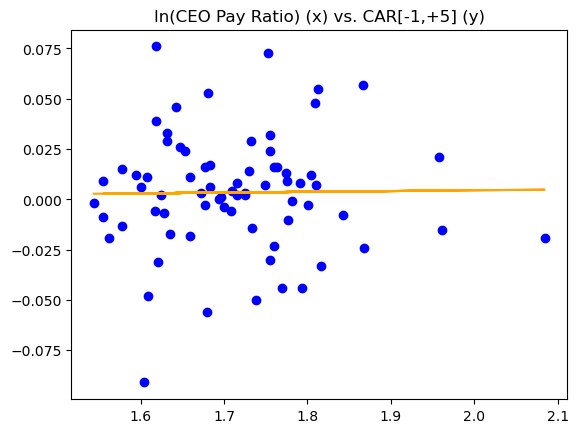

In [24]:
# visualization
df_binary = FinalMerge[['lnPayRatio', 'AbnormalReturn']]
df_binary.columns = ['Pay Ratio', 'CAR']
# df_binary.head()

# sns.lmplot(x = "Pay Ratio", y = "CAR", 
#            data = df_binary, 
#            order = 2, 
#            ci = None)

x = np.array(np.log(df_binary['Pay Ratio'])).reshape(-1, 1)
y = np.array(df_binary['CAR']).reshape(-1, 1)

model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print(f"Coefficient of Determination: {r_sq}")
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_}")

y_regr = np.array([model.coef_ * i + model.intercept_ for i in x]).reshape(-1, 1)

plt.title('ln(CEO Pay Ratio) (x) vs. CAR[-1,+5] (y)')
plt.scatter(x, y, color='blue')
plt.plot(x, y_regr, color='orange')
plt.show()